In [18]:
# necessary modules
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as mat
from collections import Counter
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

In [2]:
file=pd.read_csv('original.csv')
file.head()

,clientid,income,age,loan,default
0,1,66155.925095,59.017015,8106.532131,0
1,2,34415.153966,48.117153,6564.745018,0
2,3,57317.170063,63.108049,8020.953296,0
3,4,42709.534201,45.751972,6103.642260,0
4,5,66952.688845,18.584336,8770.099235,1


In [3]:
file=file.drop(columns=['clientid'])
file.head()

,income,age,loan,default
0,66155.925095,59.017015,8106.532131,0
1,34415.153966,48.117153,6564.745018,0
2,57317.170063,63.108049,8020.953296,0
3,42709.534201,45.751972,6103.642260,0
4,66952.688845,18.584336,8770.099235,1


In [4]:
file.describe()

,income,age,loan,default
count,2000.000000,1997.000000,2000.000000,2000.000000
mean,45331.600018,40.807559,4444.369695,0.141500
std,14326.327119,13.624469,3045.410024,0.348624
min,20014.489470,-52.423280,1.377630,0.000000
25%,32796.459717,28.990415,1939.708847,0.000000
50%,45789.117313,41.317159,3974.719419,0.000000
75%,57791.281668,52.587040,6432.410625,0.000000
max,69995.685578,63.971796,13766.051239,1.000000


In [5]:
file.dtypes

income     float64
age        float64
loan       float64
default      int64
dtype: object

In [6]:
file.isna().sum()

income     0
age        3
loan       0
default    0
dtype: int64

In [7]:
file=file.dropna()

In [8]:
file.isna().sum()

income     0
age        0
loan       0
default    0
dtype: int64

In [9]:
positive_age_rows = file['age'] >= 0
file = file[positive_age_rows]

In [10]:
file.age.min()

18.055188510566897


Correlation with 'default':
default    1.000000
loan       0.377789
income     0.002366
age       -0.445248
Name: default, dtype: float64


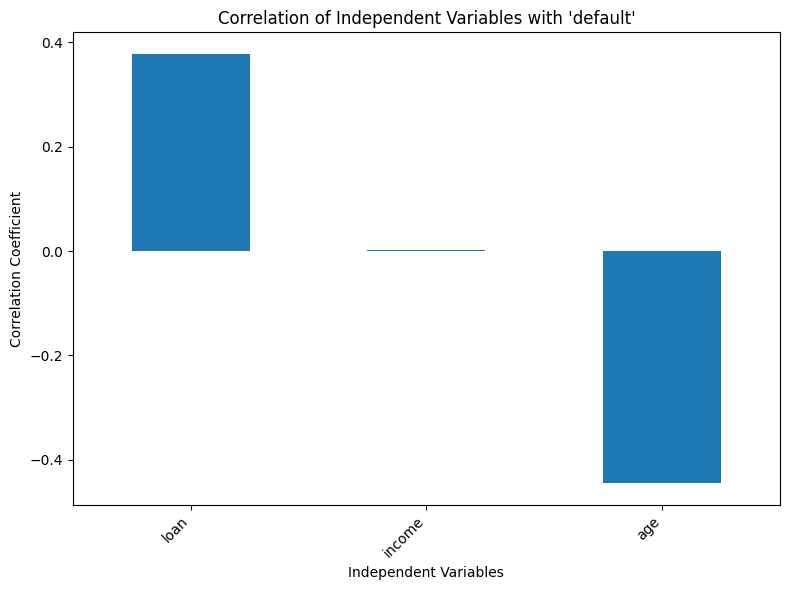

In [11]:
#correlation matrix

def check_default_correlation(df):
    if 'default' not in df.columns:
        print("Error: 'default' column not found in the DataFrame.")
        return
    numeric_df = df.select_dtypes(include=['number'])
    if numeric_df.empty:
        print("Warning: DataFrame contains no numeric columns.")
        return
    if 'default' not in numeric_df.columns:
        print("Warning: 'default' column is not numeric.")
        return
    # Calculate the correlation matrix
    correlation_matrix = numeric_df.corr()
    # Extract the correlation with the 'Churn' column
    default_correlation = correlation_matrix['default'].sort_values(ascending=False)
    print("\nCorrelation with 'default':")
    print(default_correlation)

    # Visualize the correlation with 'Churn' using a bar plot
    mat.figure(figsize=(8, 6))
    default_correlation.drop('default').plot(kind='bar') # Drop 'Default' itself from the plot
    mat.title("Correlation of Independent Variables with 'default'")
    mat.ylabel("Correlation Coefficient")
    mat.xlabel("Independent Variables")
    mat.xticks(rotation=45, ha='right')
    mat.tight_layout()
    mat.show()

check_default_correlation(file)

<Axes: xlabel='default', ylabel='loan'>

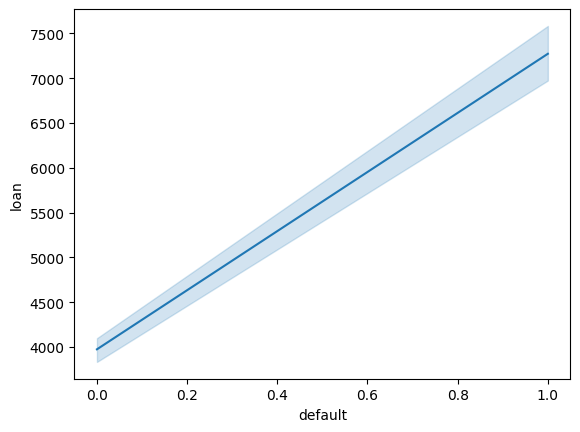

In [12]:
sb.lineplot(x=file.default,y=file.loan)

<Axes: xlabel='default', ylabel='age'>

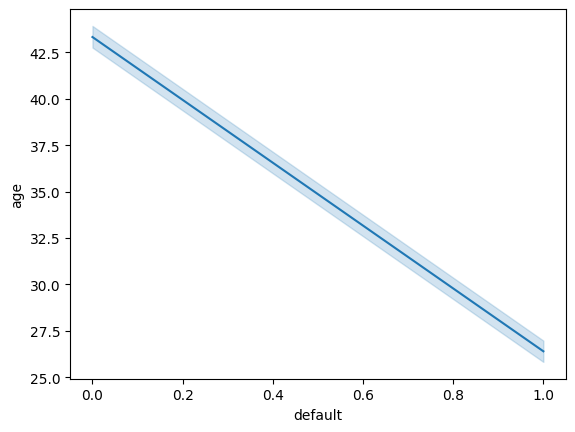

In [13]:
sb.lineplot(x=file.default,y=file.age)

In [14]:
X= file.drop(columns=['default'])
y=file.default
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

In [15]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature  
        self.threshold = threshold 
        self.left = left       
        self.right = right    
        self.value = value      

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _information_gain(self, y, y_left, y_right):
        p = len(y_left) / len(y)
        return self._entropy(y) - p * self._entropy(y_left) - (1 - p) * self._entropy(y_right)

    def _split(self, X, y, feature_index, threshold):
        left_indices = np.where(X[:, feature_index] <= threshold)[0]
        right_indices = np.where(X[:, feature_index] > threshold)[0]
        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[right_indices], y[right_indices]
        return X_left, y_left, X_right, y_right

    def _best_split(self, X, y):
        best_gain = -1
        split_idx, split_thresh = None, None

        n_samples, n_features = X.shape
        if n_samples < self.min_samples_split:
            return None, None

        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                X_left, y_left, X_right, y_right = self._split(X, y, feature_index, threshold)
                if len(y_left) > 0 and len(y_right) > 0:
                    gain = self._information_gain(y, y_left, y_right)
                    if gain > best_gain:
                        best_gain = gain
                        split_idx = feature_index
                        split_thresh = threshold
        return split_idx, split_thresh

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_labels == 1 or n_samples < self.min_samples_split:
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)
        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is not None:
            X_left, y_left, X_right, y_right = self._split(X, y, best_feature, best_threshold)
            left_child = self._grow_tree(X_left, y_left, depth + 1)
            right_child = self._grow_tree(X_right, y_right, depth + 1)
            return Node(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child)
        else:
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)

    def fit(self, X, y):
        self.root = self._grow_tree(X, y)

    def _predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def predict(self, X):
        return np.array([self._predict_one(x, self.root) for x in X])

In [16]:
clf = DecisionTree(max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [20]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.93

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       347
           1       0.68      0.87      0.76        52

    accuracy                           0.93       399
   macro avg       0.83      0.90      0.86       399
weighted avg       0.94      0.93      0.93       399


Confusion Matrix:
 [[326  21]
 [  7  45]]
